<a href="https://colab.research.google.com/github/jazkre/01ZLMA/blob/main/R/01ZLMA_ex11_Loglinear_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01ZLMA - Exercise 11
Exercise 11 of the course 01ZLMA. 

## Contents

* Log-linear models for Contingency tables
 ---


Dataset and example from Chapter 10

Peter K. Dunn • Gordon K. Smyth, Generalized Linear ModelsWith Examples in R

https://link.springer.com/content/pdf/10.1007%2F978-1-4419-0118-7.pdf

In [ ]:
install.packages("GLMsData")
library(GLMsData)
library(tidyverse)

## Two Dimensional Tables: 

A table of counts may arise from several possible sampling schemes, each suggesting a different probability model. 

* The m observations are allocated to factors A and B as the observations
randomly arrive; neither row nor column totals are fixed.
* A fixed total number of m observations are cross-classified by the factors
A and B.
* The row totals are fixed, and observations allocated to factor B within
each level of A. (Alternatively, the column total are fixed, and observations
allocated to factor A within each level of B.)

Example 10.2.
Consider a 2×2 table, where data were collected between
December 1996 and January 1997, and comprise a two-dimensional (or
two-way) table of counts collating the `attitude` of Australians to genetically modified foods (factor A) according to their `income` (factor B) 


In [ ]:
gm <- data.frame(counts = c(263, 258, 151, 222),
                 attitude = c("for","for","against","against"),
                 income = c("high","low","high","low")) %>%
      mutate(attitude = as.factor(attitude),
             income = as.factor(income))

gm
str(gm)           

In [ ]:
gm_table <- xtabs(counts ~ attitude + income, data =gm)
gm_table

The percentage of low and high income respondents who are `for` and
`against` gm foods by `income` level using prop.table():

In [ ]:
round(prop.table(gm_table, margin=2)*100, 1) # margin=2 means columns
round(prop.table(gm_table, margin=1)*100, 1) # margin=1 


In [ ]:
interaction.plot(gm$attitude, gm$income,gm$counts)

In [ ]:
#interaction.plot(gm$income,gm$counts,gm$attitude) chceli sme zameniť osi
interaction.plot(gm$income,gm$attitude,gm$counts)


### Contingency table

Model: $Y_{ij} \sim Poisson(\lambda_{ij} )$

Null (independence): $H_0 :\lambda_{ij} = \delta \cdot \alpha_i \cdot \beta_j , \sum_i \alpha_i = 1, \sum_j \beta_j = 1.$
Alternative: $H_a : \lambda_{ij} \in \mathbb{R}^+$

Test statistic: Pearson’s $X^2$ : $X^2 = \sum_{ij} \frac{(Y_{ij}-E_{ij})^2}{E_{ij}} \overset{H_0}{\approx} \chi^2_1$, where $E_{ij}$ is the estimated expected value under independence.



In [ ]:
Y = c(151,222,263,258)
N = sum(Y)

pi_a = c((151+222)/N,(263+258)/N) #cez riadky ->58%suhlasi s gmo
pi_i = c((151+263)/N,(222+258)/N) #cez stlpce -> income (zastupenir 53%)

E = N*c(pi_a[1]*pi_i[1], pi_a[1]*pi_i[2], pi_a[2]*pi_i[1], pi_a[2]*pi_i[2]) #ocekavany pocet pozor, pokial su premenne na sebe nezavisle
E



In [ ]:
# Pearson's X^2
X2 = sum((Y - E)^2/E)
p_val_X2 =  1-pchisq(X2,1)
c(X2,p_val_X2)

In [ ]:
? chisq.test

In [ ]:
chisq.test(matrix(Y,2,2), correct=FALSE)
#chisq.test(matrix(Y,2,2), correct=T)


### GLM

In [ ]:
gm_1 <- glm(counts ~ attitude + income, family=poisson,data = gm)
summary(gm_1)
anova(gm_1, test="Chisq")


income dev:8.76863	p-val: 2.721816e-02-> podobne ako chi2 ručne ale líšia sa (viď nižšie)

In [ ]:
data.frame(true = gm$counts, fitted_GLM= fitted(gm_1),expected_X2 = E[c(3,4,1,2)])



Poisson GLM  has the same fitted values as we the model computed by hand above.



In [ ]:
DEV = sum(2*(Y*log(Y/E)+Y-E))
c(X2, DEV, deviance(gm_1)) %>% round(4)
# Close but not the same

Test statists are numerically close, but not the same.

Both of these statistics have asymptotic $\chi^2$ distributions, reasonably well-approximatedwhen all expected frequencies are large.


In practice  global tests (such as Deviance or Pearson $\chi^2$) are less useful for comparing competing models.  Usully we compare competing models directly with Deviance test or AIC or BIC, respectivelly.

pokial mam poisson rozdel (konting. tab) keď poč pozor posielam do nekonečna: N do nekonečna -> chceme $n_{ij}$-> ∞ ∀i,j pak chcebe aby šli všetky? what? i dont understand, i dont comprehend 

In [ ]:

c_val_deviance = qchisq(0.05,4-3,ncp=0,lower.tail = F)
p_val_deviance = pchisq(DEV,4-3,ncp=0,lower.tail = F)


In [ ]:
data.frame(test = c("Pearson Chi2","Deviance"), 
           statistic = c(X2, DEV),
           p_val = c( p_val_X2,p_val_deviance))


The inference is the same from both models

### Interpretation

In [ ]:
coef(gm_1)

Model $gm_1$: $log(\hat{\mu}_{ij}) = \alpha + \beta_i x_i + \beta_j x_j = 5.151 + 0.3342x_i + 0.1479x_j,$

where  $x_i = 1$ for row $i = 2$ (against gm foods) and is zero otherwise, and $x_j = 1$ for column $j = 2$ (low income) and is zero otherwise.

In [ ]:
exp(5.1517)
exp(0.3342)
exp(0.1479)

Interpretation of model $gm_1$:

$ \hat{\mu}_{ij} = exp(5.486) \cdot exp(0.3342x_i) \cdot exp(0.1479x_j)
= 172.7 \cdot 1.396^{x_i} \cdot 1.159^{x_j}$,   $ \ \ \ \ x_1,x_2 \in \{0,1\}$.

Under this model, the fitted values for $\hat{\mu}_{i2}$ are always 1.159 times the fitted values for $\hat{\mu}_{i1}$, for either value of $x_1$. This ratio of the corresponding column marginal totals is:


In [ ]:
sum(gm$counts[gm$income=="low"]) / sum(gm$counts[gm$income=="high"])


The interpretaion of the estimated coefficients are following:

$exp(\beta_i) = \frac{\pi_{i \cdot}}{\pi_{1 \cdot}} = \frac{P[X=i]}{P[X=1]}$


$exp(\beta_j) = \frac{\pi_{i \cdot}}{\pi_{1 \cdot}} = \frac{P[X=i]}{P[X=1]}$

In [ ]:
exp(coef(gm_1)[2])
pi_a[2]/pi_a[1]

exp(coef(gm_1)[3])
pi_i[2]/pi_i[1]

If we want to determine the relationship between income and attitudes
towards gm foods, we have to investigate the  the interaction term in the model.



In [ ]:
gm_2 <- glm(counts ~ attitude * income, family=poisson,data = gm)



Interaction model is Saturated model and its deviance is zero. We can apply MLE theory since the number of parameters is fixed (its constant).



In [ ]:
summary(gm_2)
anova(gm_2, test="Chisq")

nejde to zjednodušiť, potrebujeme na popis všetko -> komplex info -> štat významný rozdiel

Summary

* The interaction term is necessary in the model. 

* No residual deviance remains and no residual degrees of freedom remain, so the fit is perfect. 

* The number of coefficients in the saturated model is the same as the
number of entries in the table

* The contingency table cannot be summarized by a smaller set of
model coefficients.

* The data suggest an association between income levels and attitude towards gm foods. 

Interprettion of the interaction model `X ~ attitude` and `Z ~ income`:

$exp(\beta_i) = \frac{\pi_{i 1}}{\pi_{1 1}} = \frac{P[X=i|Z =1]}{P[X=1 | Z=1]}$


$exp(\beta_j) = \frac{\pi_{1 j}}{\pi_{1 1}} = \frac{P[X=1 | Z =j]}{P[X=1 | Z =1]}$

$exp(\beta_{ij}) = \frac{\pi_{ij} \pi_{11}}{\pi_{i 1} \pi_{1j}}$

Possible cases:
* No Marginal Totals Are Fixed - previous example, no requirement in the model
* Conditioning on the Grand Total - Poisson model is  appropriate  and it is equivalent to a multinomial model iff the constant term is in the model.
* The Column (or Row) Totals Are Fixed - Poisson model is appropriate iff the coefficients in the linear predictor corresponding to fixed margins are included in the linear predictor.

## Three-Dimensional Tables

Consider three categorical random variables $A \in \{1, \ldots, I\}$, $B \in \{1, \ldots, J\}$, $C \in \{1, \ldots, K\}$ and  $n$ realizaions of this triplet to obtain a contingency table.

If the factors have I, J and K levels respectively, the table
is an I × J × K table and  $\mu_{i,j,k} $ refers to the expected count in the cell (i, j, k).



We assume following possible models:

* Mutal Independence (A,B,C) 
$$\log(\mu_{ijk}) = log(n) + log(\pi_{i \cdot \cdot}) + log(\pi_{\cdot j \cdot}) + log(\pi_{ \cdot \cdot k}) = \mu + \alpha_i + \beta_j + \gamma_k  $$

* Partial Independence (AC,B)
$$\log(\mu_{ijk}) = log(n) + log(\pi_{i j \cdot}) + log(\pi_{\cdot \cdot k}) = \mu + \alpha_i + \beta_j + \gamma_k + (\alpha \beta)_{ij}  $$

* Conditional Independence (AC,BC)
$$\log(\mu_{ijk}) = log(n) + log(\pi_{i \cdot k}) + log(\pi_{\cdot j k}) + log(\pi_{\cdot \cdot k}) = \mu + \alpha_i + \beta_j + \gamma_k + (\alpha \gamma)_{ik} + (\beta \gamma)_{jk}   $$


* Uniform Association (AB,AC,BC)
$$\log(\mu_{ijk}) =  \mu + \alpha_i + \beta_j + \gamma_k +  (\alpha \beta)_{ij} +(\alpha \gamma)_{ik} + (\beta \gamma)_{jk}   $$


* The Saturated Model (ABC)
$$\log(\mu_{ijk}) =  \mu + \alpha_i + \beta_j + \gamma_k +  (\alpha \beta)_{ij} +(\alpha \gamma)_{ik} + (\beta \gamma)_{jk} + (\alpha \beta \gamma)_{ijk}   $$




In [ ]:
data(kstones)
kstones
str(kstones)
table(kstones)

Model (ABC), i.e. (Size,Method,Outcome)

In [ ]:
ks_mutind <- glm( Counts ~ Size + Method + Outcome, family=poisson, data=kstones)
summary(ks_mutind )

In [ ]:
# Test model:
1- pchisq(deviance(ks_mutind),df.residual(ks_mutind))


In [ ]:
data.frame(fitted = fitted(ks_mutind), measured = kstones$Counts)

To plot residuals with Pearson test we can use function `mosaic`

In [ ]:
install.packages("vcd", repos="http://R-Forge.R-project.org")
#install.packages("vcd")
install.packages("gnm")
install.packages("vcdExtra", repos="http://R-Forge.R-project.org")
#install.packages("vcdExtra")
library(vcdExtra)
#https://cran.r-project.org/web/packages/vcdExtra/index.html

In [ ]:
if (!require(remotes)) install.packages("remotes")
 remotes::install_github("friendly/vcdExtra", build_vignettes = TRUE)

In [ ]:
mosaic(ks_mutind, shade=TRUE, formula = ~ Size + Method + Outcome,residuals_type="rstandard",
 labeling=labeling_residuals,main="Model: [Size][Method][Outcome]")

Not enough good model ... Find another one ....

Model (AB,C), i.e. (Size*Method,Outcome)

In [ ]:
ks_SM <- glm( Counts ~ Size * Method + Outcome, family=poisson, data=kstones )
#ks_SO <- update(ks.SM, . ~ Size * Outcome + Method)
#ks_OM <- update(ks.SM, . ~ Outcome * Method + Size)

summary(ks_SM)
#summary(ks_SO)
#summary(ks_OM)



Model (AB,AC), i.e. (Size* Method, Size * Outcome)

In [ ]:
ks_noMO <- glm( Counts ~ Size * (Method + Outcome), family=poisson, data=kstones )  #f
#ks_noOS <- update(ks.noMO, . ~ Method * (Outcome + Size) )
#ks_noMS <- update(ks.noMO, . ~ Outcome * (Method + Size) )

summary(ks_noMO)
#summary(ks_noOS)
#summary(ks_noMS)



Model (AB,AC,BC), i.e. (Size * Method,Size * Outcome, Method * Outcome)

In [ ]:
ks_no3 <- glm( Counts ~ Size*Method*Outcome - Size:Method:Outcome,family=poisson, data=kstones )
#ks_no3b <- glm( Counts ~ (Size+Method+Outcome)^2,family=poisson, data=kstones )

summary(ks_no3)
#summary(ks_no3b)


Saturated model

If the saturated model is appropriate, then the data cannot be
presented in a simpler form than giving the original I × J × K table.



In [ ]:
ks_sat <- glm( Counts ~ Size * Method * Outcome, family=poisson, data=kstones )
#deviance(ks_sat)
#df.residual(ks_sat)


In [ ]:
drop1(ks_no3,test="Chisq")

Today's tasks:

* From previous 5 models choose the right one. What will be your approach?
Hint: Find the the simplest suitable model. 

* Interpret your final model. Which variables are independent? 

* Which Method is more successfull, A or B? Which method is more successfull for Large stones? 

* What is the odds ratio of succes if we consider small stone compare to large one?

* Use Logit model for previous data and compare results from Logit model to Poisson model. Is the outcome from the logit model same?

 Equivalent loglinear and logit models for a three-way table, with `C` as a binary response variable.

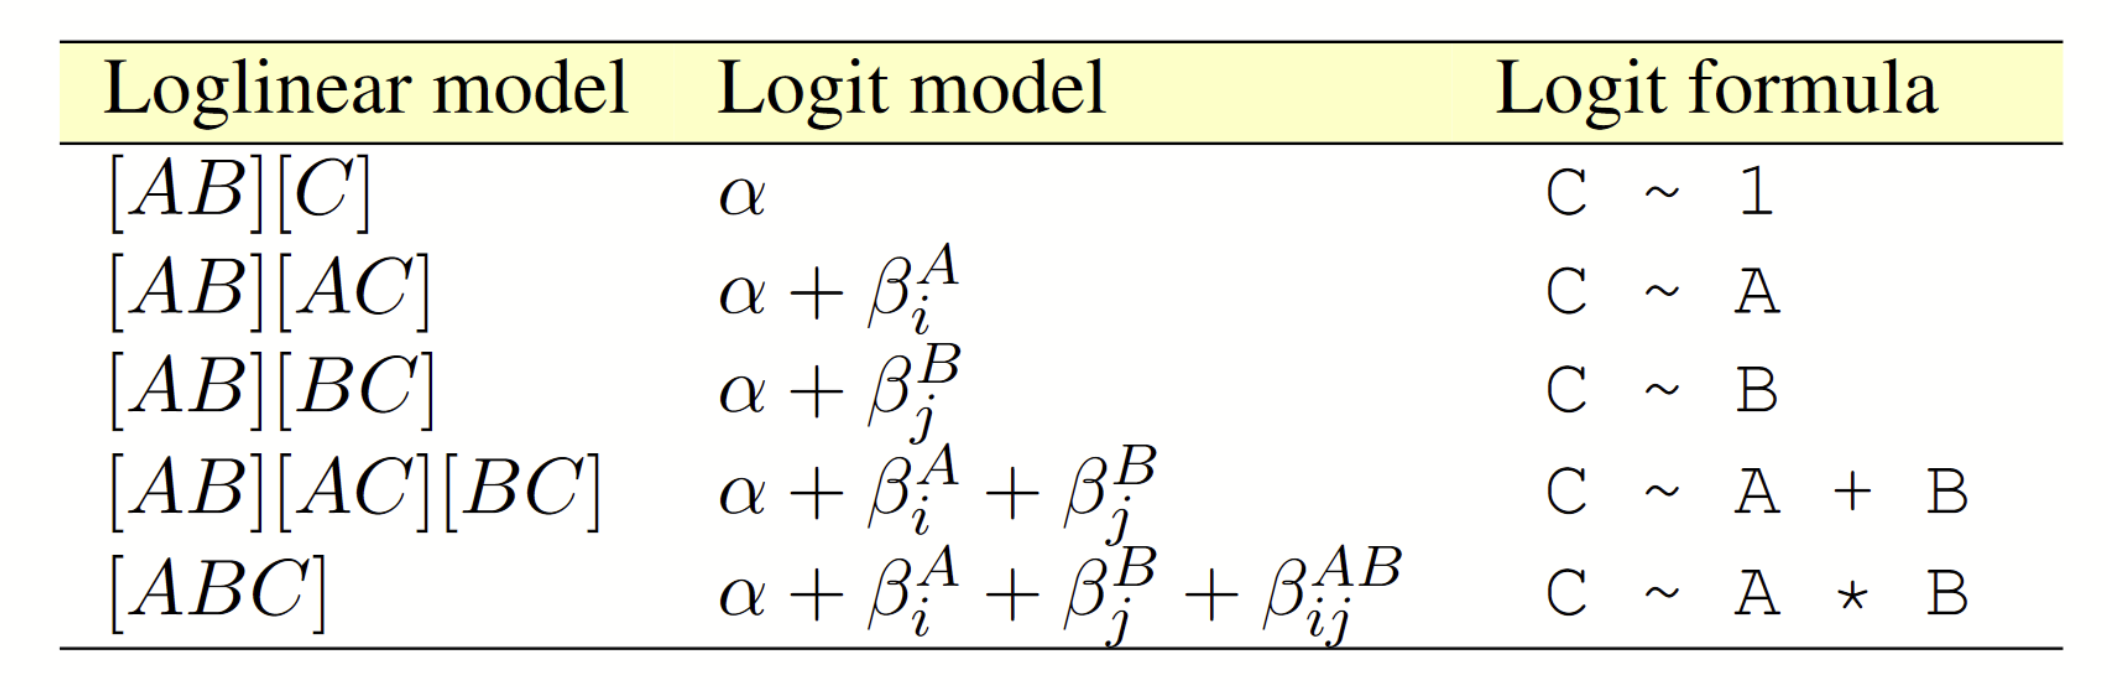

In [ ]:
print("_________________________________________________")
print("ks_mutind")
print("_________________________________________________")
summary(ks_mutind )
print("_________________________________________________")
print("ks_SM")
print("_________________________________________________")
summary(ks_SM)
print("_________________________________________________")
print("ks_noMO")
print("_________________________________________________")
summary(ks_noMO)
print("_________________________________________________")
print("ks_no3")
print("_________________________________________________")
summary(ks_no3)
print("_________________________________________________")
print("ks_sat")
print("_________________________________________________")
summary(ks_sat)

In [ ]:
ks_dalsi<-glm(Counts ~ Size * Method * Outcome - Size:Method:Outcome - Method:Outcome , family = poisson, data = kstones)
summary(ks_dalsi)